# Мое решение Задачи 4 "Место залежей нефти и газа"

Я работаю на удаленном сервер с ГПУ через VS code. Поэтому у меня нет кода который загружает или скачивает данные с Google Colab.

In [1]:
# установим AutoML фреймворк от Сбера - LightAutoML(LAMA)
# это позволит довольно быстро проверять различные гипотезы и 
# отбирать лучшие решения.
# !pip install -U lightautoml

In [2]:
# иморитирование всех необходимых библиотек
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

# импорты из LightAutoML
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Считывание данных

In [3]:
# Считываем тренировочные данные
train = pd.read_csv("data/train_oil.csv")

print(f"Train dataset shape: {train.shape}")

Train dataset shape: (309, 20)


In [4]:
# Считываем тестовые данные
test = pd.read_csv("data/oil_test.csv")

print(f"Test dataset shape: {test.shape}")

Test dataset shape: (133, 19)


In [5]:
# Посмотрим как выглядят данные
train.head()

,Field name,Reservoir unit,Country,Region,Basin name,Tectonic regime,Latitude,Longitude,Operator company,Onshore/Offshore,Hydrocarbon type,Reservoir status,Structural setting,Depth,Reservoir period,Lithology,Thickness (gross average ft),Thickness (net pay average ft),Porosity,Permeability
0,ZHIRNOV,MELEKESKIAN,RUSSIA,FORMER SOVIET UNION,VOLGA-URAL,COMPRESSION/EVAPORITE,51.0000,44.8042,NIZHNEVOLZHSKNET,ONSHORE,OIL,DECLINING PRODUCTION,FORELAND,1870,CARBONIFEROUS,SANDSTONE,262.0,33.0,24.0,30.0
1,LAGOA PARDA,LAGOA PARDA (URUCUTUCA),BRAZIL,LATIN AMERICA,ESPIRITO SANTO,EXTENSION,-19.6017,-39.8332,PETROBRAS,ONSHORE,OIL,NEARLY DEPLETED,PASSIVE MARGIN,4843,PALEOGENE,SANDSTONE,2133.0,72.0,23.0,350.0
2,ABQAIQ,ARAB D,SAUDI ARABIA,MIDDLE EAST,THE GULF,COMPRESSION/EVAPORITE,26.0800,49.8100,SAUDI ARAMCO,ONSHORE,OIL,REJUVENATING,FORELAND,6050,JURASSIC,LIMESTONE,250.0,184.0,21.0,410.0
3,MURCHISON,BRENT,UK /NORWAY,EUROPE,NORTH SEA NORTHERN,EXTENSION,61.3833,1.7500,CNR,OFFSHORE,OIL,NEARLY DEPLETED,RIFT,8988,JURASSIC,SANDSTONE,425.0,300.0,22.0,750.0
4,WEST PEMBINA,NISKU (PEMBINA L POOL),CANADA,NORTH AMERICA,WESTERN CANADA,COMPRESSION,53.2287,-115.8008,NUMEROUS,ONSHORE,OIL,UNKNOWN,FORELAND,9306,DEVONIAN,DOLOMITE,233.0,167.0,11.8,1407.0


In [6]:
# Посмотрим на возможные значения переменной 
train["Onshore/Offshore"].unique()

array(['ONSHORE', 'OFFSHORE', 'ONSHORE-OFFSHORE'], dtype=object)

И так у нас три класса: 'ONSHORE', 'OFFSHORE', 'ONSHORE-OFFSHORE'

In [7]:
# закодируем целевую переменную в числа
train["Onshore/Offshore"] = train["Onshore/Offshore"].replace({"OFFSHORE":0, "ONSHORE":1, "ONSHORE-OFFSHORE":2})

In [8]:
# проверим результат кодировки
train["Onshore/Offshore"].unique()

array([1, 0, 2])

In [9]:
# Посмотрим как выглядят данные
test.head()

,Field name,Reservoir unit,Country,Region,Basin name,Tectonic regime,Latitude,Longitude,Operator company,Hydrocarbon type,Reservoir status,Structural setting,Depth,Reservoir period,Lithology,Thickness (gross average ft),Thickness (net pay average ft),Porosity,Permeability
0,ABU GHARADIG,BAHARIYA,EGYPT,AFRICA,ABU GHARADIG,EXTENSION,29.7422,28.4925,GUPCO,GAS-CONDENSATE,MATURE PRODUCTION,RIFT,10282,CRETACEOUS,SANDSTONE,745.0,144.0,10.0,8.0
1,ABU MADI-EL QARA,ABU MADI (LEVEL III),EGYPT,AFRICA,NILE DELTA,STRIKE-SLIP/TRANSTENSION/SHALE/EVAPORITE/BASEM...,31.4382,31.3616,IEOC,GAS,DECLINING PRODUCTION,WRENCH/DELTA,10499,NEOGENE,SANDSTONE,509.0,410.0,20.0,300.0
2,ALIBEKMOLA,KT I,KAZAKHSTAN,FORMER SOVIET UNION,CASPIAN NORTH,COMPRESSION/EVAPORITE,48.4740,57.6667,KAZAKHOIL AKTOBE,OIL,DEVELOPING,SUB-SALT/FORELAND,6000,CARBONIFEROUS,LIMESTONE,300.0,105.0,10.0,20.0
3,ALWYN NORTH,BRENT (BRENT EAST),UK,EUROPE,NORTH SEA NORTHERN,INVERSION/COMPRESSION/EXTENSION,60.7833,1.7333,TOTAL,OIL,NEARLY DEPLETED,RIFT,9790,JURASSIC,SANDSTONE,886.0,344.0,17.0,500.0
4,ANKLESHWAR,ANKLESHWAR (HAZAD-ARDOL),INDIA,FAR EAST,CAMBAY,STRIKE-SLIP/TRANSPRESSION/BASEMENT-I,21.6000,72.9167,ONGC,OIL,MATURE PRODUCTION,WRENCH/RIFT,2950,PALEOGENE,SANDSTONE,670.0,0.0,21.0,250.0


In [10]:
target = "Onshore/Offshore"

## Исследование данных

Прежде чем переходить к непосредственному построению модели, в первую очередь необходимо исследовать имеющихся у вас набор данных:
1. Какую задачу вы решаете (классификация, регрессия) и какая переменная является целевой?
2. Сколько переменных в данных и какого они типа?
3. Имеются ли в данных пропуски?

In [11]:
print("Number of missing values in train dataset:")
print(train.isna().sum())
print("Number of missing values in test dataset:")
print(test.isna().sum())

Number of missing values in train dataset:
Field name                         0
Reservoir unit                     0
Country                           27
Region                            38
Basin name                        38
Tectonic regime                    0
Latitude                          27
Longitude                         30
Operator company                   0
Onshore/Offshore                   0
Hydrocarbon type                   0
Reservoir status                   0
Structural setting                 0
Depth                              0
Reservoir period                   0
Lithology                          0
Thickness (gross average ft)       0
Thickness (net pay average ft)     0
Porosity                           0
Permeability                       0
dtype: int64
Number of missing values in test dataset:
Field name                         0
Reservoir unit                     0
Country                           13
Region                            16
Basin name    

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Field name                      309 non-null    object 
 1   Reservoir unit                  309 non-null    object 
 2   Country                         282 non-null    object 
 3   Region                          271 non-null    object 
 4   Basin name                      271 non-null    object 
 5   Tectonic regime                 309 non-null    object 
 6   Latitude                        282 non-null    float64
 7   Longitude                       279 non-null    float64
 8   Operator company                309 non-null    object 
 9   Onshore/Offshore                309 non-null    int64  
 10  Hydrocarbon type                309 non-null    object 
 11  Reservoir status                309 non-null    object 
 12  Structural setting              309 

**Проверим баланс классов.**

В задаче классификации данные называются несбалансированными (Imbalanced Data), если в обучающей выборке доли объектов разных классов существенно различаются, также говорят, что «классы не сбалансированы».

In [13]:
train[target].value_counts()

1    218
0     86
2      5
Name: Onshore/Offshore, dtype: int64

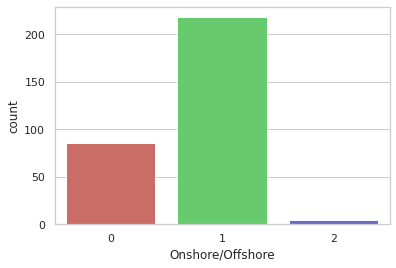

In [14]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
y_data = pd.DataFrame(train[target])
sns.countplot(x=target, data=y_data, palette='hls')
plt.show()

В задаче три класса, при этом класс "ONSHORE-OFFSHORE" невероятно малочисленный.
Есть ощущение, что возможно этот класс вообще можно удалить.

Так и поступим, выбросим строчки с классом "ONSHORE-OFFSHORE", которому был присвоен номер 2.
Модель тоже будем обучать только на классы "OFFSHORE":0, "ONSHORE":1.

In [15]:
# удалим все ряды train["Onshore/Offshore"] == 2 (класс "ONSHORE-OFFSHORE")
index_names = train[train[target] == 2].index
print(index_names)
train.drop(index_names , inplace=True)

Int64Index([64, 92, 134, 185, 220], dtype='int64')


In [17]:
# проверим остались ли ряды train["Onshore/Offshore"] == 2 (класс "ONSHORE-OFFSHORE")
len(train[train[target] == 2])

0

## Предобработка данных

Исходя из анализа данных, можно сделать выводы:
- в данных пропуски есть их мало, но SberAutoML умеет подбирать стратегию их заполнения на основе метрик. (Сейчас я сильно тороплюсь поэтому оставлю этот выбор за фреймворком)
- в данных имеются категориальные признаки
- в задаче решается задача классификации. Три класса, один невероятно малочисленный скорее всего модель его не выучит. Возможно стоит рассмотреть задачу бинарной классификации. И выкинуть данные о классе "ONSHORE-OFFSHORE".
- существует небольшой дисбаланс классов: (класс 0) примерно в два раза меньше, чем класс 1. Класс 2 вообще практически не представлен.

### Кодирование признаков

**Категориальные признаки называют по-разному: факторными, номинальными.**

Их значения определяют факт принадлежности к какой-то категории. Примеры таких признаков: пол, страна проживания, номер группы, категория товаров и т.п. Ясно, что для компьютерной обработки вместо «понятного для человека» значения (в случае страны — ‘Russia’, ‘GB’, ‘France’ и т.п.) хранят числа. 

**Категориальные** признаки называют по-разному: **факторными**, **номинальными**. Их значения определяют факт принадлежности к какой-то категории. 

Примеры таких признаков: пол, страна проживания, номер группы, категория товаров и т.п. Ясно, что для компьютерной обработки вместо «понятного для человека» значения (в случае страны — ‘Russia’, ‘GB’, ‘France’ и т.п.) хранят числа.

In [18]:
# Перечислим колонки которые являются категоритальными признаками
# выбрали датафраме test, чтобы в списке признаков не было целевой переменной

category_features = []
for col_name in test.loc[:, train.dtypes == object].columns:
    print(col_name)
    category_features.append(col_name)

Field name
Reservoir unit
Country
Region
Basin name
Tectonic regime
Operator company
Hydrocarbon type
Reservoir status
Structural setting
Reservoir period
Lithology


In [19]:
# Перечислим колонки которые являются количественными(числовыми) признаками
# выбрали датафраме test, чтобы в списке признаков не было целевой переменной

numeric_features = []
for col_name in test.loc[:, train.dtypes != object].columns:
    print(col_name)
    numeric_features.append(col_name)

Latitude
Longitude
Depth
Thickness (gross average ft)
Thickness (net pay average ft)
Porosity
Permeability


У используемой мной библиотеки lightAutoLM от Сбера есть своя встроенная обработка категориальных данных.
Нам нужно пр постановке задачи просто указать какие колонки являются количественными(числовыми), а какие категориальными.
Что мы и сделаем.

Бывает, что распределения числовых признаков в предоставленных данных могут сильно отличаться.
Например, некоторый параметр "цена бронирования" имеет в train выборе распределение от 0 до 1000, а в тесте от 5000 до 10000.
Таким образом модель обученная по выборке train будет работать в диапазоне значений который не встречается в test выборке.
Простейший способ борьбы с этим явлением - избавиться от такого признака при обучении модели.

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


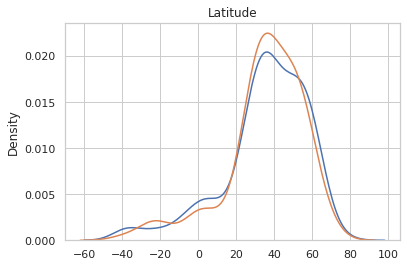

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


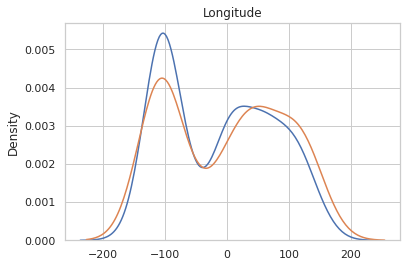

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


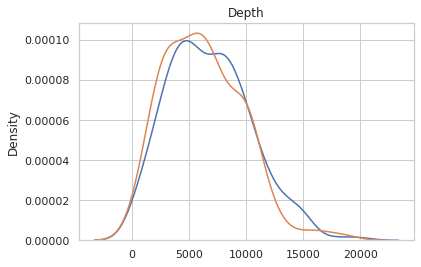

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


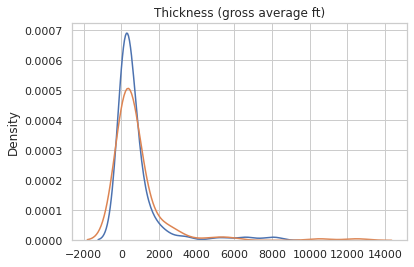

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


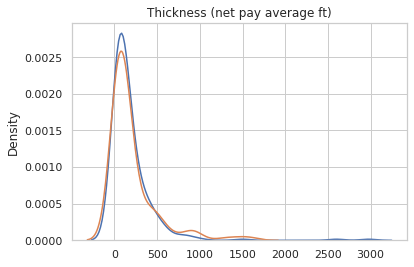

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


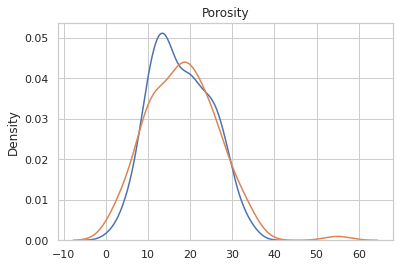

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


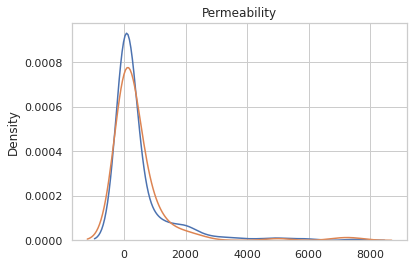

In [20]:
# Мы хотим посмотреть распределения значений у количественных признаков между выборками train и test

for col_i in test.loc[:, train.dtypes != object].columns:
    sns.distplot(train[[col_i]], hist=False)
    sns.distplot(test[[col_i]], hist=False)
    plt.title(col_i)
    plt.show()

## Вывод -  выборки train и test гомогенны
Мы видим, что распределения очень похожи а выборки train и test - гомогенны. Можно работать со всеми числовыми признаками )

## Разделяем train-выборку на train (80%) и val(20%)

In [21]:
# Разобьем выборку на обучающую и валидационную
tr_data, valid_data = train_test_split(train, 
                                       test_size=0.2, 
                                       stratify=train[target], 
                                       random_state=42)

print(f'Parts sizes: tr_data = {tr_data.shape}, valid_data = {valid_data.shape}')

Parts sizes: tr_data = (243, 20), valid_data = (61, 20)


## Обучение модели

Теперь наши данные готовы для обучения модели.

## Ставим задачу машинного обучения используем все

In [25]:
# https://lightautoml.readthedocs.io/en/latest/python_api/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task
task = Task('binary', loss= 'logloss', metric = 'logloss')

In [26]:
category_features

['Field name',
 'Reservoir unit',
 'Country',
 'Region',
 'Basin name',
 'Tectonic regime',
 'Operator company',
 'Hydrocarbon type',
 'Reservoir status',
 'Structural setting',
 'Reservoir period',
 'Lithology']

In [27]:
numeric_features

['Latitude',
 'Longitude',
 'Depth',
 'Thickness (gross average ft)',
 'Thickness (net pay average ft)',
 'Porosity',
 'Permeability']

In [28]:
roles = {'target': target,
         'numeric': numeric_features,
         'category': category_features
         }

In [29]:
# Эксперименты показали, что в итоговой блендинг модели наибольший вклад
# около 95% имеет модель градиентного бустинга lgb.
# Вклад Логистической регрессии с l2-регуляризацией менее 1%.
# Вклад градиентного бустинга CatBoost составил 5%.
# В итоговом решении я оставил только эту модель.
automl = TabularAutoML(task = task, 
                    timeout = 3600 * 3, # 3600 секунд = 1 час
                    general_params = {'use_algos': [['cb', 'lgb', 'linear_l2']]},
                    cb_params = {'default_params': {'task_type': 'GPU'}},
                    reader_params = {'n_jobs': 12},
                    timing_params ={'mode': 0}
                    )

In [30]:
# запускаем обучение на данных и подбор оптимальных параметров
# из ансамбля моделей
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose=4)

[10:33:52] Stdout logging level is DEBUG.
[10:33:52] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[10:33:52] Task: binary

[10:33:52] Start automl preset with listed constraints:
[10:33:52] - time: 10800.00 seconds
[10:33:52] - CPU: 4 cores
[10:33:52] - memory: 16 GB

[10:33:52] Train data shape: (243, 20)

[10:33:53] Feats was rejected during automatic roles guess: []
[10:33:53] Layer 1 train process start. Time left 10799.29 secs
[10:33:53] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[10:33:53] Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [29, 30, 31, 32, 33, 34, 35, 36], 'embed_sizes': array([11,  9,  9,  5,  9, 12,  9, 11], dtype=int32), 'data_size': 37}
[10:33:53] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[10:33:53] Linear mo

/home/admin-gpu/anaconda3/envs/sber_lama/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


[10:33:53] Linear model: C = 0.5 score = -0.2549548637698628
[10:33:53] Linear model: C = 1 score = -0.2729066414309993
[10:33:53] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[10:33:53] Linear model: C = 1e-05 score = -0.596284028218717
[10:33:53] Linear model: C = 5e-05 score = -0.5886192528568969
[10:33:53] Linear model: C = 0.0001 score = -0.5798180839236902
[10:33:53] Linear model: C = 0.0005 score = -0.5288161866518916
[10:33:53] Linear model: C = 0.001 score = -0.49165049651447607
[10:33:53] Linear model: C = 0.005 score = -0.40178858887936386
[10:33:53] Linear model: C = 0.01 score = -0.3728093587204206
[10:33:53] Linear model: C = 0.05 score = -0.34003639918257844
[10:33:53] Linear model: C = 0.1 score = -0.3418564826454397
[10:33:53] Linear model: C = 0.5 score = -0.3904690580476403
[10:33:53] ===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[10:33:53] Linear model: C = 1e-05 score = -0.5828537233173847
[10:33:53] Linear model: C 

Тут некоторая тонкость использования метдов **automl.fit_predict()** и **automl.predict()**.

Когда automl обучает модели методом **fit_predict()** это происходит с помощью кросс валидации (в нашем случае на 5 подвыборках из обучающей выборки). 

В процессе этого **automl** будет собирать статистику по фолдам, которые в данный момент являются валидационными и записывать ее.

Поэтому и предсказанные значения по валидационным фолдам и полученные по ней метрики будут получены из метода automl.fit_predict(обучающая_выборка).

automl.predict(данные) использует уже готовый полученный ансамбль моделей МЛ, некакого разбиения на подвыборки тут нет. Его праивльно использовать на тестовой выборке, - тех данных которые не участвовали при обучени модели.

Предсказывать на automl.predict(обучающая_выборка) не правильно, таким образом мы померим метрику на тех данных на которых учили модель. А правильно делать это только на валлидационых фолдах при кросс валидации.

### Сохраним полученный ансамбль моделей в файл

In [31]:
model_path = 'model/lightautoml_model_1.pkl'
oof_pred_path = 'model/lightautoml_model_1_oof_pred_1.pkl'

In [33]:
# сохраним полученный ансамбль моделей и его предсказания на тестовой выборке
joblib.dump(automl, model_path)
joblib.dump(oof_pred, oof_pred_path)

['model/lightautoml_model_1_oof_pred_1.pkl']

### Загрузим сохраненую ранее модель из файла

In [34]:
porog = 0.5

In [35]:
automl = joblib.load(model_path)
oof_pred = joblib.load(oof_pred_path)

In [36]:
# проверка полученного ансамбля на валидационной выборке
valid_pred = automl.predict(valid_data)

In [37]:
valid_pred = (valid_pred.data[:, 0] > porog).astype(int)
valid_pred

array([1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1])

In [38]:
np.unique(valid_pred, return_counts=True)

(array([0, 1]), array([15, 46]))

In [40]:
valid_y_true = valid_data[target].values
valid_y_true

array([1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1])

In [41]:
np.unique(valid_y_true, return_counts=True)

(array([0, 1]), array([17, 44]))

In [42]:
# соберем данные для оценки метрик по фолдам кросс валидации
cross_val_train_y_true = tr_data[target].values
cross_val_train_pred = (oof_pred.data[:, 0] > porog).astype(int)

In [43]:
# оценка полученной метрики на валидационном наборе данных
from sklearn.metrics import accuracy_score, precision_score, recall_score

print(f"Кросс валидация accuracy_score: {accuracy_score(cross_val_train_y_true, cross_val_train_pred)}")
print(f"Валидационная выборка accuracy_score: {accuracy_score(valid_y_true, valid_pred)}")

print(f"Кросс валидация precision_score: {precision_score(cross_val_train_y_true, cross_val_train_pred)}")
print(f"Валидационная выборка  precision_score: {precision_score(valid_y_true, valid_pred)}")

print(f"Кросс валидация precision_score: {recall_score(cross_val_train_y_true, cross_val_train_pred)}")
print(f"Валидационная выборка precision_score: {recall_score(valid_y_true, valid_pred)}")

Кросс валидация accuracy_score: 0.8641975308641975
Валидационная выборка accuracy_score: 0.8360655737704918
Кросс валидация precision_score: 0.8852459016393442
Валидационная выборка  precision_score: 0.8695652173913043
Кросс валидация precision_score: 0.9310344827586207
Валидационная выборка precision_score: 0.9090909090909091


## Обучение модели на всей обучающей выборке и предсказание на тестовых данных

Мы подобрали параметры обучения убедились что они работают хорошо по кросс валидации по 5 фолдам на 80% обучающей выборки.
И протестировали наш алгоритм на 20% валидационной выборки.

Теперь мы используя все подобранные параметры и настройки просто обучим алгоритм МЛ на кросс валидации по 5 фолдам, но уже на всей обучающей выборке. 

Согласно лучшим практикам встречающимся на kaggle это дает дополнительный прирост к точности за счет расширения выборки обучающих данных для модели. Контроль метрик и ранней остановки обучения идет по метрикам на валидационной выборке каждого фола из кросс валидации.
И является распространенной практикой используемой при работе с LightAutoML от Сбера (ссылка на туториалы https://github.com/sb-ai-lab/LightAutoML#google-colab-tutorials-and-other-examples).

In [44]:
# https://lightautoml.readthedocs.io/en/latest/python_api/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task
task = Task('binary', loss= 'logloss', metric = 'accuracy')

In [45]:
roles = {'target': target,
         'numeric': numeric_features,
         'category': category_features
         }

In [46]:
# Эксперименты показали, что в итоговой блендинг модели наибольший вклад
# около 95% имеет модель градиентного бустинга lgb.
# Вклад Логистической регрессии с l2-регуляризацией менее 1%.
# Вклад градиентного бустинга CatBoost составил 5%.
# В итоговом решении я оставил только эту модель.
automl = TabularAutoML(task = task, 
                    timeout = 3600 * 3, # 3600 секунд = 1 час
                    general_params = {'use_algos': [['cb', 'lgb', 'linear_l2']]},
                    cb_params = {'default_params': {'task_type': 'GPU'}},
                    reader_params = {'n_jobs': 12},
                    timing_params ={'mode': 0}
                    )

In [47]:
# обучение этим подходом на всех имеющиеся обучающих данных
oof_pred = automl.fit_predict(train, roles = roles, verbose=4)

[10:37:06] Stdout logging level is DEBUG.
[10:37:06] Task: binary

[10:37:06] Start automl preset with listed constraints:
[10:37:06] - time: 10800.00 seconds
[10:37:06] - CPU: 4 cores
[10:37:06] - memory: 16 GB

[10:37:06] Train data shape: (304, 20)

[10:37:06] Feats was rejected during automatic roles guess: []
[10:37:06] Layer 1 train process start. Time left 10799.90 secs
[10:37:06] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[10:37:06] Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [26, 27, 28, 29, 30, 31, 32, 33, 34], 'embed_sizes': array([ 4, 12, 11, 10,  8, 12,  9, 11, 11], dtype=int32), 'data_size': 35}
[10:37:06] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[10:37:06] Linear model: C = 1e-05 score = 0.7213114754098361
[10:37:06] Linear model: C = 5e-05 score = 0.721311475409836

### Сохраним полученный ансамбль моделей в файл

In [48]:
model_path = 'model/lightautoml_model_1_final.pkl'
oof_pred_path = 'model/lightautoml_model_1_oof_pred_final.pkl'

In [49]:
# сохраним полученный ансамбль моделей и его предсказания на тестовой выборке
joblib.dump(automl, model_path)
joblib.dump(oof_pred, oof_pred_path) 

['model/lightautoml_model_1_oof_pred_final.pkl']

### Загрузим сохраненую ранее модель из файла

In [50]:
automl = joblib.load(model_path)
oof_pred = joblib.load(oof_pred_path)

In [51]:
# оценка полученной метрики на всем наборе данных
# теперь мы можем оценить полученные метрики только по кросс валидации
cross_val_train_y_true = train[target].values
cross_val_train_pred = (oof_pred.data[:, 0] > porog).astype(int)

metric = accuracy_score(cross_val_train_y_true, cross_val_train_pred)
print(f"Кросс валидация(вся выборка) accuracy_score: {metric}")


Кросс валидация(вся выборка) accuracy_score: 0.881578947368421


## Предсказание ответа для тестового набора данных

In [52]:
# предсказание ансамблем моделей на тестовых данных
test_pred = automl.predict(test)

### Сделаем файл sabmita

In [53]:
submission_path = 'submission/lightautoml_model_final_submission.csv'

In [54]:
y_pred_test = (test_pred.data[:, 0] > porog).astype(int)
y_pred_test

array([1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

In [55]:
submit=pd.DataFrame({"Onshore/Offshore":y_pred_test})
submit.index.name="index"
submit["Onshore/Offshore"]=submit["Onshore/Offshore"].replace({0:"OFFSHORE", 1:"ONSHORE"})

In [56]:
submit

,Onshore/Offshore
index,
0,ONSHORE
1,OFFSHORE
2,ONSHORE
3,OFFSHORE
4,ONSHORE
...,...
128,ONSHORE
129,ONSHORE
130,ONSHORE


In [57]:
submit.to_csv(submission_path)